## <center> Pomoćne funkcije

In [6]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.io

try:
    import mpld3
    mpld3.enable_notebook()
    print("Modul mpld3 is installed.")
except:
    print("Modul mpld3 is NOT installed.")

def plot_signal(x, x_label = "", y_label = "", title = "", show = True):
    plt.plot(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_spectrum(x, x_label = "", y_label = "", title = "", dB = True, show = True):
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x)))
    if dB:
        X = 20 * np.log10(X)
        X -= np.max(X)
    plt.plot(F, X)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def gen_FIR(n_FIR, D, transition_width):
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    fir_coeff = signal.firls(n_FIR, fir_freqs, fir_response, fs = 1)
    return fir_coeff

def plot_FIR(fir_coeff, x_label = "", y_label = "", title = "", show = True):
    w, h = signal.freqz(fir_coeff)
    H = 20 * np.log10(abs(h))
    plt.plot(w / (2 * np.pi), H)
    plt.plot([1 / (2 * D) - transition_width, 1 / (2 * D) - transition_width], [np.min(H), 0], "r--")
    plt.plot([1 / (2 * D), 1 / (2 * D)], [np.min(H), 0], "r--");
    plt.plot([1 / (2 * D) + transition_width, 1 / (2 * D) + transition_width], [np.min(H), 0], "r--")
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def stem_FIR(x, x_label = "", y_label = "", title = "", show = True):
    plt.stem(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();
    
def compresor(x, D):
    ''' Downsample the signal by factor D
           x - input signal
           D - downsampling factor '''
    return x[::D]

def make_polyphase(coeff, M):
    # Split coefficients into polyphase components
    n = int(np.ceil(len(coeff) / M))
    tmp = np.zeros(n * M)
    tmp[:len(coeff)] = coeff
    poly_coeff = np.zeros((M, n))
    for i in range(M):
        poly_coeff[i, :] = tmp[i::M]
    return poly_coeff

def decimate_polyphase_(x, coeff, D):
    x_periodic = np.concatenate((x, x[:len(coeff) - 1]))
    poly_coeff = make_polyphase(coeff, D)
    res = 0
    for i in range(D):
        FIR_in = x_periodic[i::D]
        tmp = signal.lfilter(poly_coeff[D - 1 - i], 1.0, FIR_in)
        tmp = tmp[int(len(coeff) / D):]
        res += tmp
    return res

def show(A):
    print(f"{A: <+1.15f}  ", end="")       # float
    print(f"{A:>5q}  ", end="")           # Q format
    print(f"{A:0{A.m+(A.m-1)//4}_bm}." if A.m else ".", end="")
    print(f"{A:0{A.n}_bn}" if A.n else "") # Show binary point

def gen_test_spectrum(n, freq, amp, rand_phase = False):
    ''' Generate test spectrum
         Arguments:
            n    - number of samples
            freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
            amp  - tuple of amplitudes (ampStart, ampEnd)
            randPhase - if True, assign random phase to each sample '''
    freq_start, freq_end = freq
    amp_start, amp_end = amp
    ind_start = round(n * freq_start)
    ind_end = round(n * freq_end)

    x = np.zeros(n, dtype = "complex128")
    x[ind_start : ind_end] = amp_start - np.linspace(0, 1, num = ind_end - ind_start) * (amp_start - amp_end)
    if rand_phase:
        x[ind_start : ind_end] *= np.exp(1j * 2 * np.pi * np.random.rand(ind_end - ind_start))
    x[0] = abs(x[1]) / 2

    x_time_domain = np.fft.ifft(x)
    return x_time_domain

def to_fixed_point_array(arr, n, m = 1, sign = True):
    fixed_arr = []
    for i in range(len(arr)):
        fixed_arr_ = float(FixedPoint(arr[i], sign, m = 1, n = n - m))
        fixed_arr.append(fixed_arr_)
    fixed_arr = np.array(fixed_arr)
    return fixed_arr

def to_FixedPoint_array(arr, n, m = 1, sign = True):
    arr_FP = []
    for i in range(len(arr)):
        arr_FP.append(FixedPoint(arr[i], signed = sign, m = m, n = n, overflow = 'clamp', rounding='convergent'))
    return arr_FP

def fixed_point_FIR(coeff, x, m = 1, N = 16, ndarray = True):
    coeff_fixed = to_fixed_point_array(fir_coeff, N, m = 1, sign = True)
    x_fixed = to_fixed_point_array(x, N, m = 1, sign = True)

    y = []
    for i in range(len(x)):
        acc = FixedPoint(0, signed = True, m = 2 * m, n = 2 * N - m, overflow = 'clamp', rounding='convergent')
        for j in range(len(coeff)):
            if i - j >= 0:
                acc += coeff[j] * x_fixed[i - j]
                acc.resize(2*m, 2*N - m)
        acc.resize(m, N - m)
        y.append(acc)

    if ndarray:
        y_ = y
        y = []
        for i in range(len(y_)):
            y.append(float(y_[i]))
        y = np.array(y)
    return y

def fixed_decimate_polyphase(x, coeff, D, m = 1, N = 16, ndarray = True):
    x_periodic = np.concatenate((x, x[:len(coeff) - 1]))
    poly_coeff = make_polyphase(coeff, D)
    res_ = np.zeros(len(x) // D)
    res = to_FixedPoint_array(arr = res_, n = N - m, m = m, sign = True)
    show(res[100])
    print(len(res))

    for i in range(D):
        FIR_in = x_periodic[i::D]
        tmp_ = fixed_point_FIR(coeff = poly_coeff[D - 1 - i], x = FIR_in, m = m, N = N, ndarray = True)
        tmp_ = tmp_[int(len(coeff) / D):]
        print(len(tmp_))
        tmp = to_FixedPoint_array(arr = tmp_, n = N - m, m = m, sign = True)

        for j in range(len(tmp_)):
            res[j] += tmp[j]
            res[j].resize(m, N - m)
        # tmp = signal.lfilter(poly_coeff[D - 1 - i], 1.0, FIR_in)
        
    return res

Modul mpld3 is installed.


## <center> Polifazna decimacija signala u float-point aritmetici

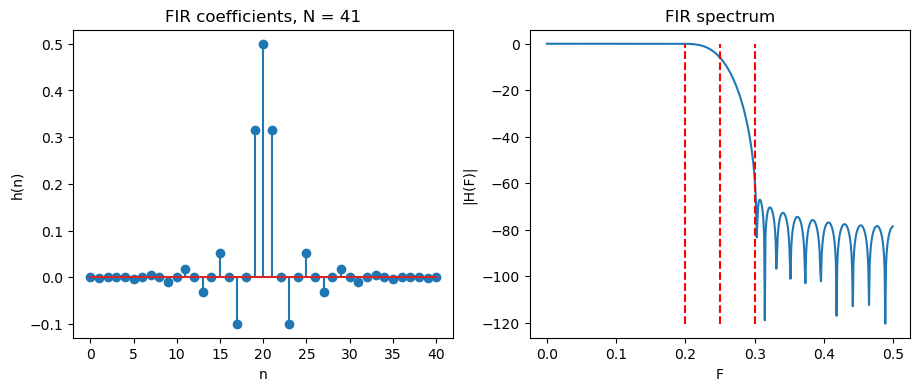

In [7]:
n_FIR = 41
D = 2
transition_width = 0.05

fir_coeff = gen_FIR(n_FIR, D, transition_width)

figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, figH))
plt.subplot(1, 2, 1)
stem_FIR(fir_coeff, 'n', "h(n)", f"FIR coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(1, 2, 2)
plot_FIR(fir_coeff, 'F', "|H(F)|", "FIR spectrum", show = False)

In [8]:
print("Koeficijenti FIR filtra: ")
print(fir_coeff)
print("")
print("Koeficijenti polifazne dekompozicije FIR filtra: ")
print(make_polyphase(fir_coeff, D))

Koeficijenti FIR filtra: 
[ 2.14033284e-14 -3.87431523e-04 -5.59753488e-14  1.25551281e-03
  1.11172966e-13 -2.98183186e-03 -1.88470553e-13  6.02057004e-03
  2.85835818e-13 -1.09890517e-02 -3.97312875e-13  1.88267269e-02
  5.13316762e-13 -3.12934644e-02 -6.22096267e-13  5.27556579e-02
  7.11141255e-13 -9.92251809e-02 -7.69635166e-13  3.15959025e-01
  5.00000000e-01  3.15959025e-01 -7.69635166e-13 -9.92251809e-02
  7.11141255e-13  5.27556579e-02 -6.22096267e-13 -3.12934644e-02
  5.13316762e-13  1.88267269e-02 -3.97312875e-13 -1.09890517e-02
  2.85835818e-13  6.02057004e-03 -1.88470553e-13 -2.98183186e-03
  1.11172966e-13  1.25551281e-03 -5.59753488e-14 -3.87431523e-04
  2.14033284e-14]

Koeficijenti polifazne dekompozicije FIR filtra: 
[[ 2.14033284e-14 -5.59753488e-14  1.11172966e-13 -1.88470553e-13
   2.85835818e-13 -3.97312875e-13  5.13316762e-13 -6.22096267e-13
   7.11141255e-13 -7.69635166e-13  5.00000000e-01 -7.69635166e-13
   7.11141255e-13 -6.22096267e-13  5.13316762e-13 -3.9731

In [9]:
import pprint

file_path = r"..\sonar_signals.mat"

# Load the .mat file
mat_data = scipy.io.loadmat(file_path)
pprint.pprint(mat_data)

rx_chirp = np.array(mat_data['rxChirp'])[0]
tx_chirp = np.array(mat_data['txChirp'])[0]

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Dec '
               b'23 13:58:14 2019',
 '__version__': '1.0',
 'rxChirp': array([[-0.01074549,  0.01935746, -0.02677989, ..., -0.29115609,
        -0.0517339 , -0.11006995]]),
 'txChirp': array([[ 0.00000000e+00,  2.11679388e-05,  3.22258987e-05, ...,
        -3.20730812e-05,  2.61708263e-05, -0.00000000e+00]])}


In [10]:
mixed = rx_chirp * tx_chirp
mixed_d = decimate_polyphase(mixed, fir_coeff, D)

plot_spectrum(mixed_d, 'F', "|X(F)| dB", f"Decimated product of TX and RX channels, N = {len(mixed_d)}", dB = True, show = False)

NameError: name 'decimate_polyphase' is not defined

In [11]:
time = 0.01       # In seconds
c = 1500          # In m/s
fs = 200e3        # In Hz
f_start = 20e3    # In Hz
f_end = 60e3      # In Hz
slope = (f_end - f_start) / time

mixed_signal = rx_chirp * tx_chirp
mixed_decimated = decimate_polyphase(mixed_signal, fir_coeff, D)

n = len(mixed_decimated)
F = np.fft.fftfreq(n)[:n//2]
dist = F * (fs / D) * c / 2 / slope

X = abs(np.fft.fft(mixed_decimated))[:n//2]
X_dB = 20 * np.log10(X)
X_dB -= np.max(X_dB)
# Threshold value
th = -10
# Find peaks above the threshold
peaks, _ = signal.find_peaks(X_dB, height = th)
# Convert indeces to distances 
distance_peaks = np.array(peaks) / n * (fs / D) * c / 2 / slope

fig = plt.figure(figsize = (6, 4))
plt.plot(dist, X_dB)
plt.plot(distance_peaks, X_dB[peaks], "x")
# Annotate each peak with its distance
for i, peak in enumerate(distance_peaks):
    plt.annotate(f'{peak:.2f} m', (peak + 0.3, X_dB[peaks][i]))
plt.xlabel("Distance [m]"); plt.ylabel("|X| dB"); plt.title(f"Spectrum of TX and RX channel product, fs = {round(fs / D / 1e3)} kHz");
plt.ylim([-70, 10]);

plt.savefig("final_result.pdf");

NameError: name 'decimate_polyphase' is not defined

## <center> Polifazna decimacija signala u fixed-point aritmetici

In [12]:
from fixedpoint import FixedPoint
import zplane


def show(A):
    print(f"{A: <+1.15f}  ", end="")       # float
    print(f"{A:>5q}  ", end="")           # Q format
    print(f"{A:0{A.m+(A.m-1)//4}_bm}." if A.m else ".", end="")
    print(f"{A:0{A.n}_bn}" if A.n else "") # Show binary point

def gen_test_spectrum(n, freq, amp, rand_phase = False):
    ''' Generate test spectrum
         Arguments:
            n    - number of samples
            freq - tuple of digital frequencies (startFreq, endFreq) in range (0, 0.5)
            amp  - tuple of amplitudes (ampStart, ampEnd)
            randPhase - if True, assign random phase to each sample '''
    freq_start, freq_end = freq
    amp_start, amp_end = amp
    ind_start = round(n * freq_start)
    ind_end = round(n * freq_end)

    x = np.zeros(n, dtype = "complex128")
    x[ind_start : ind_end] = amp_start - np.linspace(0, 1, num = ind_end - ind_start) * (amp_start - amp_end)
    if rand_phase:
        x[ind_start : ind_end] *= np.exp(1j * 2 * np.pi * np.random.rand(ind_end - ind_start))
    x[0] = abs(x[1]) / 2

    x_time_domain = np.fft.ifft(x)
    return x_time_domain

def to_fixed_point_array(arr, n, m = 1, sign = True):
    fixed_arr = []
    for i in range(len(arr)):
        fixed_arr_ = float(FixedPoint(arr[i], sign, m = 1, n = n - m))
        fixed_arr.append(fixed_arr_)
    fixed_arr = np.array(fixed_arr)
    return fixed_arr

def to_FixedPoint_array(arr, n, m = 1, sign = True):
    arr_FP = []
    for i in range(len(arr)):
        arr_FP.append(FixedPoint(arr[i], signed = sign, m = m, n = n, overflow = 'clamp', rounding='convergent'))
    return arr_FP

def fixed_point_FIR(coeff, x, m = 1, N = 16, ndarray = True):
    coeff_fixed = to_fixed_point_array(fir_coeff, N, m = 1, sign = True)
    x_fixed = to_fixed_point_array(x, N, m = 1, sign = True)

    y = []
    for i in range(len(x)):
        acc = FixedPoint(0, signed = True, m = 2 * m, n = 2 * N - m, overflow = 'clamp', rounding='convergent')
        for j in range(len(coeff)):
            if i - j >= 0:
                acc += coeff[j] * x_fixed[i - j]
                acc.resize(2*m, 2*N - m)
        acc.resize(m, N - m)
        y.append(acc)

    if ndarray:
        y_ = y
        y = []
        for i in range(len(y_)):
            y.append(float(y_[i]))
        y = np.array(y)
    return y

def fixed_decimate_polyphase(x, coeff, D, m = 1, N = 16, ndarray = True):
    x_periodic = np.concatenate((x, x[:len(coeff) - 1]))
    poly_coeff = make_polyphase(coeff, D)
    res_ = np.zeros(len(x) // D)
    res = to_FixedPoint_array(arr = res_, n = N - m, m = m, sign = True)
    show(res[100])
    print(len(res))

    for i in range(D):
        FIR_in = x_periodic[i::D]
        tmp_ = fixed_point_FIR(coeff = poly_coeff[D - 1 - i], x = FIR_in, m = m, N = N, ndarray = True)
        tmp_ = tmp_[int(len(coeff) / D):]
        print(len(tmp_))
        tmp = to_FixedPoint_array(arr = tmp_, n = N - m, m = m, sign = True)

        for j in range(len(tmp_)):
            res[j] += tmp[j]
            res[j].resize(m, N - m)
        # tmp = signal.lfilter(poly_coeff[D - 1 - i], 1.0, FIR_in)
        
    return res

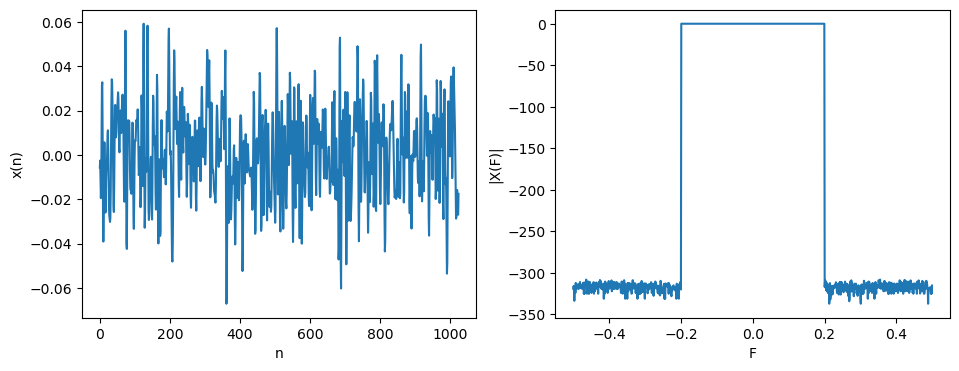

In [13]:
D = 2
n = 1024
f_max = 0.2
f = [0.0, f_max]
a = [1.0, 1.0]
x = 2*gen_test_spectrum(n, f, a, True).real
figH = 4
plt.subplots(1,2,figsize=(2.8*figH,figH))
plt.subplot(1,2,1)
plot_signal(x, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plot_spectrum(x, 'F', '|X(F)|')

In [14]:
print("Koeficijenti FIR filtra: ")
print(fir_coeff)

fir_fixed_coeff = to_fixed_point_array(fir_coeff, 16, sign = True, m = 1)
print("\nKoeficijenti FIR filtra u Q15 formatu: ")
print(fir_fixed_coeff)

fir_fixed_coeff_poly = make_polyphase(fir_fixed_coeff, D)

print("\nKoeficijenti polifazne dekompozicije FIR filtra u Q15 formatu:")
print(fir_fixed_coeff_poly)

Koeficijenti FIR filtra: 
[ 2.14033284e-14 -3.87431523e-04 -5.59753488e-14  1.25551281e-03
  1.11172966e-13 -2.98183186e-03 -1.88470553e-13  6.02057004e-03
  2.85835818e-13 -1.09890517e-02 -3.97312875e-13  1.88267269e-02
  5.13316762e-13 -3.12934644e-02 -6.22096267e-13  5.27556579e-02
  7.11141255e-13 -9.92251809e-02 -7.69635166e-13  3.15959025e-01
  5.00000000e-01  3.15959025e-01 -7.69635166e-13 -9.92251809e-02
  7.11141255e-13  5.27556579e-02 -6.22096267e-13 -3.12934644e-02
  5.13316762e-13  1.88267269e-02 -3.97312875e-13 -1.09890517e-02
  2.85835818e-13  6.02057004e-03 -1.88470553e-13 -2.98183186e-03
  1.11172966e-13  1.25551281e-03 -5.59753488e-14 -3.87431523e-04
  2.14033284e-14]

Koeficijenti FIR filtra u Q15 formatu: 
[ 0.00000000e+00 -3.96728516e-04  0.00000000e+00  1.25122070e-03
  0.00000000e+00 -2.99072266e-03  0.00000000e+00  6.01196289e-03
  0.00000000e+00 -1.09863281e-02  0.00000000e+00  1.88293457e-02
  0.00000000e+00 -3.12805176e-02  0.00000000e+00  5.27648926e-02
  0.0

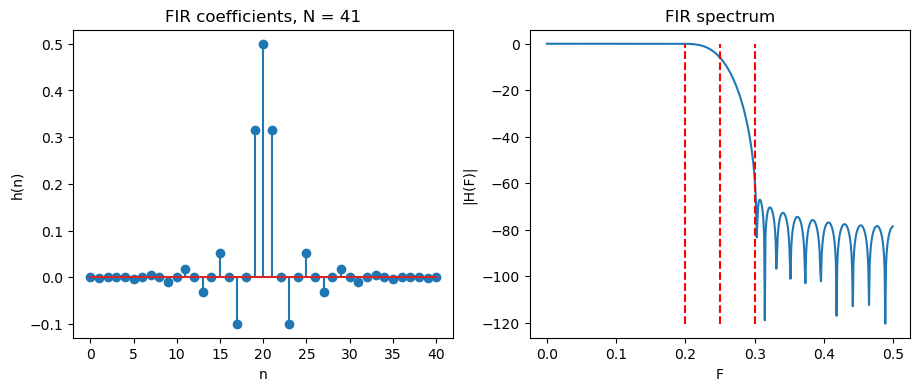

In [15]:
figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, figH))
plt.subplot(1, 2, 1)
stem_FIR(fir_coeff, 'n', "h(n)", f"FIR coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(1, 2, 2)
plot_FIR(fir_coeff, 'F', "|H(F)|", "FIR spectrum", show = False)

In [16]:
# y = fixed_point_FIR(coeff = fir_coeff, x = x, m = 1, N = 16, ndarray = False)
y_ = fixed_decimate_polyphase(x = x, coeff = fir_coeff, D = D, m = 1, N = 16, ndarray = False)

+0.000000000000000  Q1.15  0.0_0000_0000_0000
512
512
512


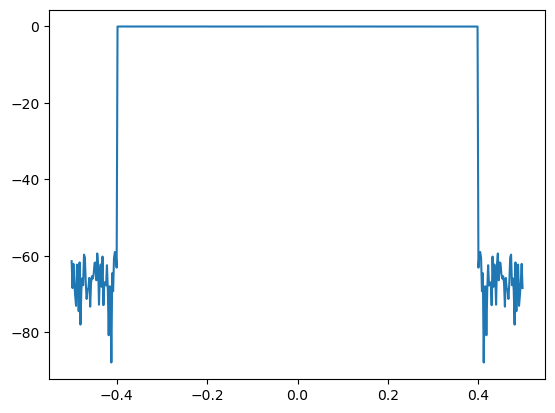

In [17]:
y = to_fixed_point_array(y_, 1, 15)

plot_spectrum(y)

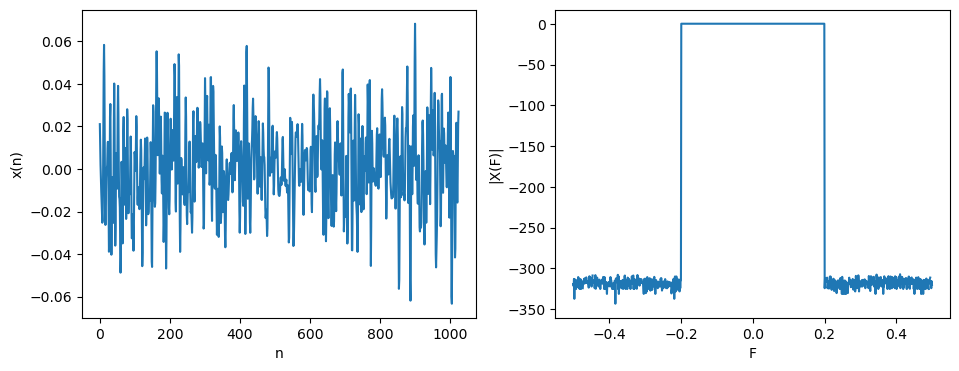

In [18]:
D = 2
n = 1024
f_max = 0.2
f = [0.0, f_max]
a = [1.0, 1.0]
x = 2*gen_test_spectrum(n, f, a, True).real
figH = 4
plt.subplots(1,2,figsize=(2.8*figH,figH))
plt.subplot(1,2,1)
plot_signal(x, 'n', 'x(n)', show=False)
plt.subplot(1,2,2)
plot_spectrum(x, 'F', '|X(F)|')

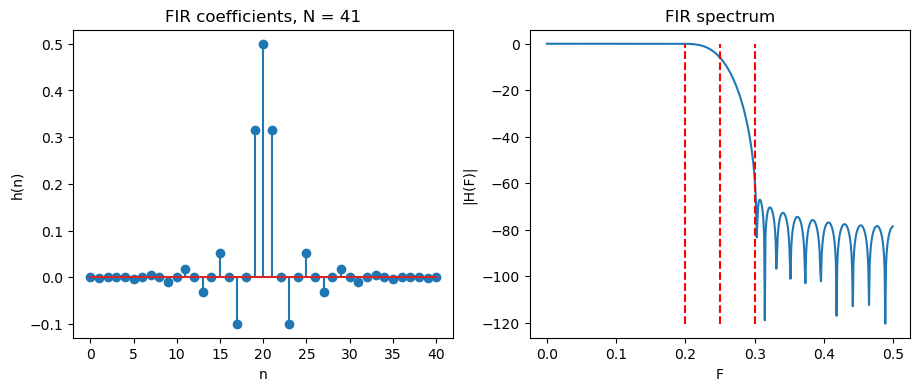

In [19]:
n_FIR = 41
D = 2
transition_width = 0.05

fir_coeff = gen_FIR(n_FIR, D, transition_width)

figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, figH))
plt.subplot(1, 2, 1)
stem_FIR(fir_coeff, 'n', "h(n)", f"FIR coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(1, 2, 2)
plot_FIR(fir_coeff, 'F', "|H(F)|", "FIR spectrum", show = False)

In [20]:
delay_line = np.zeros(n_FIR + 1)
for i in range(len(x)):
    pass

In [57]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import scipy.io
import pprint

class CircBuff:
    """ Class that implements a not-yet-full buffer. """
    
    def __init__(self, buff_size):
        self.buff_size = buff_size
        self.data = np.zeros(buff_size)
        self.curr_pos = 0
        self.cnt = 0

    def __len__(self):
        """ Retuturn the size of buffer. """
        return self.buff_size

    class __Full:
        """ Class that implements full buffer. It changes the way add and get works. """
        
        def add(self, x):
            """ Add new element to overwrite oldest element in the buffer. """
            self.data[self.curr_pos] = x
            self.curr_pos = (self.curr_pos + 1) % self.buff_size

        def get(self):
            """ Return buffer in correct order. """
            return np.concatenate((self.data[self.curr_pos:], self.data[:self.curr_pos]))

    def add(self, x):
        """ Add new element to the end of buffer. """
        self.data[self.curr_pos] = x
        self.curr_pos += 1
        self.cnt += 1
        if(self.cnt == self.buff_size):
            # Initializing current position attribute
            self.curr_pos = 0
            # Permanently change self's class from not-yet-full to full
            self.__class__ = self.__Full

    def get(self):
        """ Return buffer in correct order. """
        return self.data

def plot_signal(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots signal in Time domain. """
    plt.plot(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_spectrum(x, x_label = "", y_label = "", title = "", dB = True, show = True):
    """ Function that plots signal in Frequency domain. """
    n = len(x)
    F = np.fft.fftshift(np.fft.fftfreq(n))
    X = np.fft.fftshift(abs(np.fft.fft(x, n)))
    if dB:
        X = 20 * np.log10(X)
        X -= np.max(X)
    plt.plot(F, X)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def plot_FIR(fir_coeff, x_label = "", y_label = "", title = "", show = True):
    """ Function that plots FIR impulse response in dB. """
    w, h = signal.freqz(fir_coeff)
    H = 20 * np.log10(abs(h))
    plt.plot(w / (2 * np.pi), H)
    plt.plot([1 / (2 * D) - transition_width, 1 / (2 * D) - transition_width], [np.min(H), 0], "r--")
    plt.plot([1 / (2 * D), 1 / (2 * D)], [np.min(H), 0], "r--");
    plt.plot([1 / (2 * D) + transition_width, 1 / (2 * D) + transition_width], [np.min(H), 0], "r--")
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def stem_FIR(x, x_label = "", y_label = "", title = "", show = True):
    """ Function that stems FIR's coeffitients. """
    plt.stem(x)
    plt.xlabel(x_label); plt.ylabel(y_label); plt.title(title);
    if show:
        plt.show();

def gen_FIR(n_FIR, D, transition_width):
    """ Function that generates FIR coeffitients based on number of coeffitients and transititon zone. """
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    fir_coeff = signal.firls(n_FIR, fir_freqs, fir_response, fs = 1)
    return fir_coeff

def gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True):
    """ Function that generates FIR coeffitients based on ripple in pass band and attenuation in non-passed band. """
    num_taps = n_FIR
    fir_response = [1.0, 1.0, 0.0, 0.0]
    fir_freqs = [0.0, 1 / (2 * D) - transition_width, 1 / (2 * D) + transition_width, 0.5]
    if not symetric:
        fir_freqs[2] = 1 / (2 * D)
        
    while(True):
        fir_coeff = signal.firls(num_taps, fir_freqs, fir_response, fs = 1)
        w, h = signal.freqz(fir_coeff)
        H = 20 * np.log10(abs(h))
        ripple_ = np.max(H[:int(len(H) * 2*fir_freqs[1])]) - np.min(H[:int(len(H) * 2*fir_freqs[1])])
        attenuation_ = np.max(H[int(len(H) * 2*fir_freqs[2]):])
        if(ripple_ <= ripple and -attenuation_ >= attenuation):
            break
        else:
            num_taps += 2
    return fir_coeff
    
def make_polyphase_coeff(coeff, M):
    """ Function that generates polyphase coeffitients out of FIR coeffititents. """
    n = int(np.ceil(len(coeff) / M))
    tmp = np.zeros(M * n)
    tmp[:len(coeff)] = coeff
    poly_coeff = np.zeros((M, n))
    for m in range(M):
        poly_coeff[m, :] = tmp[m::M]
    return poly_coeff

# def FIR(x, fir_coeff):
#     """ Function that performs direct FIR filtering. """
#     y = np.zeros(len(x))
#     fir_coeff_ = fir_coeff[:, np.newaxis]             # Reshape array fir_coeff to [1, N]
#     delay_line = CircBuff(len(fir_coeff))             # Configure delay_line as circular buffer
#     for i in range(len(x)):
#         delay_line.add(x[i])
#         delay_line_ = np.array(delay_line.get())[np.newaxis, :]    # Reshape delay_line to [N, 1]
#         y[i] = delay_line_ @ fir_coeff_                            # Perform matrix multiplication
#     return y

# def FIR(x, fir_coeff):
#     """ Function that performs direct FIR filtering. """
#     n = len(x)
#     m = len(fir_coeff)
#     x = np.concatenate((x, np.zeros(m)))
#     y = np.zeros(n + m - 1)
#     delay_line = CircBuff(m)
#     for i in range(n + m - 1):
#         delay_line.add(x[i])
#         delay_line_ = delay_line.get()
#         acc = 0
#         for j in range(m):
#             acc += delay_line_[j] * fir_coeff[j]
#         y[i] = acc
#     y = y[int((m-1)/2):]
#     return y

def FIR(x, fir_coeff, state = None):
    N = len(x)
    M = len(fir_coeff)
    if state == None:
        delay_line = np.zeros(M)
    else:
        delay_line = state
    y = np.zeros(N)
    for n in range(N):
        delay_line[1:] = delay_line[:M-1]
        delay_line[0] = x[n]
        for m in range(M):
            y[n] += delay_line[m] * fir_coeff[m]
    return y

# def polyphase_decimate(x, fir_coeff, D):
#     """ Function that performs polyphase decimation. """
#     poly_coeff = make_polyphase_coeff(fir_coeff, D)
#     x_periodic = np.concatenate((x, x[:len(fir_coeff)-1]))
#     y = 0
#     for d in range(D):
#         fir_in = x_periodic[d::D]
#         tmp = FIR(fir_in, poly_coeff[D - 1 - d])
#         # tmp = signal.lfilter(poly_coeff[D - 1 - d], 1.0, fir_in)
#         tmp = tmp[int(len(fir_coeff)/D):]
#         y += tmp
#     return y

def polyphase_decimate(x, fir_coeff):
    pass


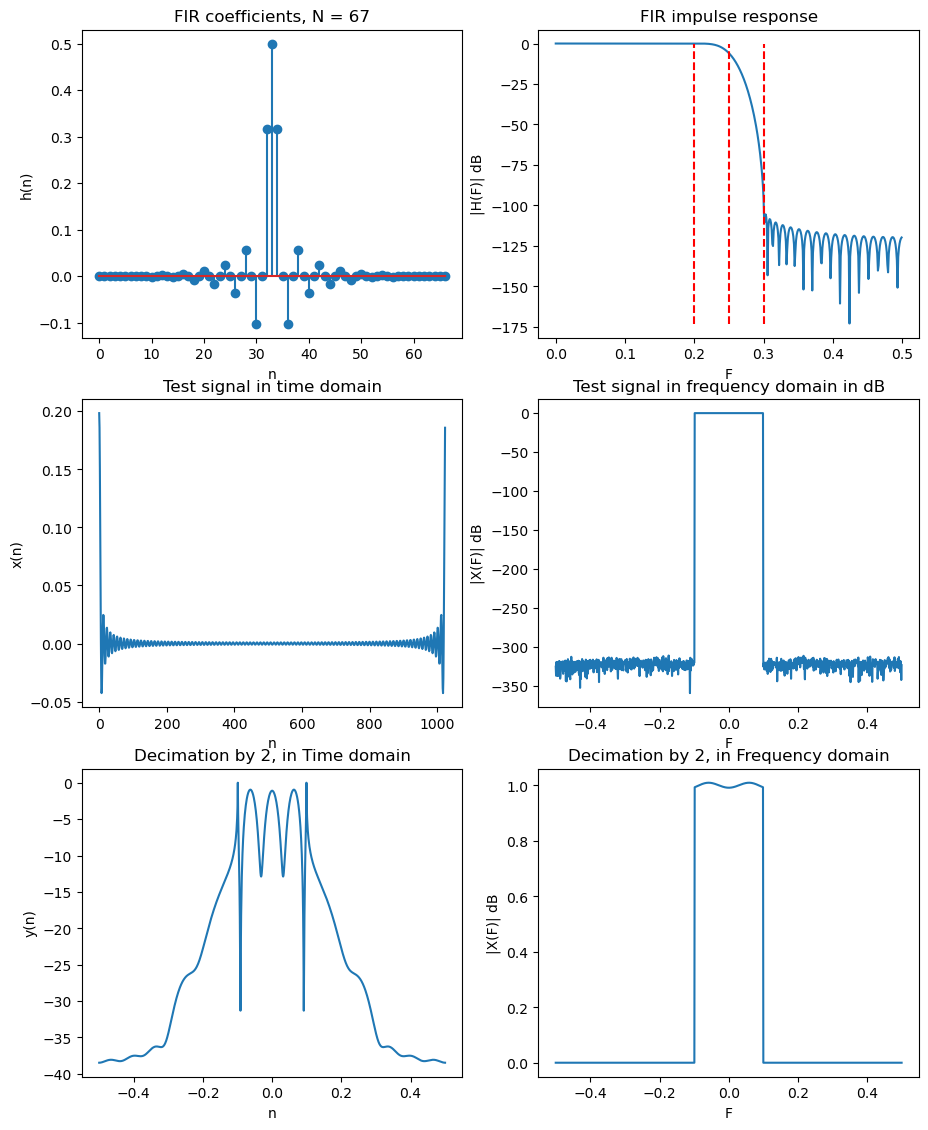

In [80]:
D = 2

n = 1024
f_max = 0.1
f = [0.0, f_max]
a = [1.0, 1.0]
x = 2*gen_test_spectrum(n, f, a, False).real

n_FIR = 1
ripple = 1e-4
attenuation = 80 # in dB
transition_width = 0.05
fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)



figH = 4
ax_x = 3; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.7 * figH, 3.4 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(fir_coeff, 'n', "h(n)", f"FIR coefficients, N = {len(fir_coeff)}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(fir_coeff, 'F', "|H(F)| dB", "FIR impulse response", show = False)
plt.subplot(ax_x, ax_y, 3)
plot_signal(x, 'n', 'x(n)', "Test signal in time domain",  show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(x, 'F', '|X(F)| dB', "Test signal in frequency domain in dB", dB = True, show = False)
plt.subplot(ax_x, ax_y, 5)
plot_spectrum(x_fir, 'n', 'y(n)', "Decimation by 2, in Time domain",  show = False)
plt.subplot(ax_x, ax_y, 6)
plot_spectrum(x_fir_, 'F', '|X(F)| dB', "Decimation by 2, in Frequency domain", dB = False, show = False)

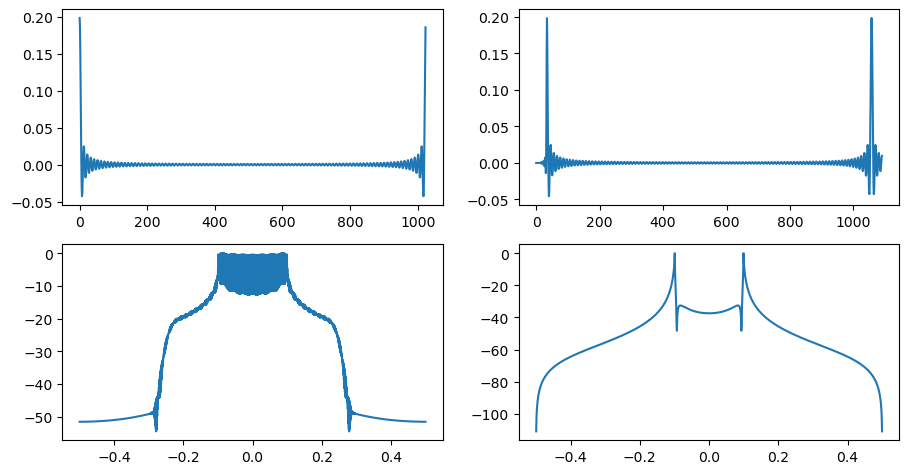

In [84]:
x_ = np.concatenate((x, x[:len(fir_coeff)]))
x_fir = FIR(x_, fir_coeff)
# x_fir = x_fir[len(fir_coeff):]
x_fir_ = signal.lfilter(fir_coeff, 1, x)
x_fir_ = x_fir_[len(fir_coeff):]

y = np.zeros(2*1024)
y[:len(x_fir)] = x_fir

figH = 4
ax_x = 2; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.7 * figH, 1.4 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_signal(x, show = False)
plt.subplot(ax_x, ax_y, 2)
plot_signal(x_fir, show = False)
plt.subplot(ax_x, ax_y, 3)
plot_spectrum(y, show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(x_fir_, show = False)

1350 327
1024 1024


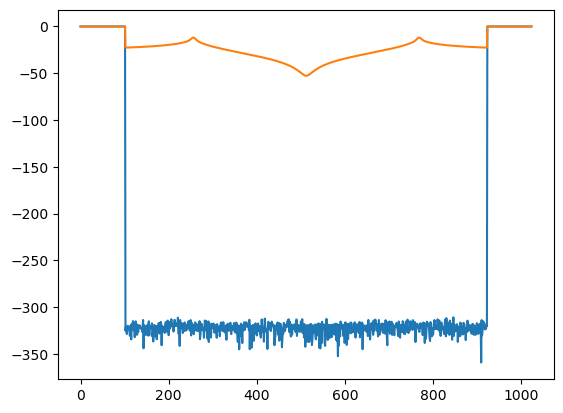

In [171]:
def fir_conv(x, coeff):
    y = np.convolve(x, coeff)
    # y = y[:-len(coeff)//2+1]
    # print(len(y))
    return y

n = 1024
f_max = 0.1
f = [0.0, f_max]
a = [1.0, 1.0]
x = 2*gen_test_spectrum(n, f, a, False).real

F1 = 0.1 
F2 = 0.4 
N = 256
n = np.arange(N) 
# x = np.sin(2*np.pi*F1*n) + np.sin(2*np.pi*F2*n)

D = 2
n_FIR = 1
ripple = 1e-4
attenuation = 80 # in dB
transition_width = 0.01
fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)

M = len(fir_coeff)
x_ = np.concatenate((x, x[:len(x)//2]))
y = fir_conv(x, fir_coeff)
# y_ = y[M//2:]
print(len(y), M)
# y_ = y[M//2:]
y_ = y[M//2:-M//2+1]

print(len(x), len(y_))


# plt.plot(x)
# plt.plot(y_)

x_fft = np.fft.fft(x)
y_fft = np.fft.fft(y_)

x_fft_dB = 20*np.log10(abs(x_fft))
x_fft_dB -= np.max(x_fft_dB)
y_fft_dB = 20*np.log10(abs(y_fft))
y_fft_dB -= np.max(y_fft_dB)

plt.plot(x_fft_dB)
plt.plot(y_fft_dB)

# figH = 4
# ax_x = 2; ax_y = 2
# plt.subplots(ax_x, ax_y, figsize=(2.7 * figH, 1.4 * figH))
# plt.subplot(ax_x, ax_y, 1)
# plot_signal(x, show = False)
# plt.subplot(ax_x, ax_y, 2)
# plot_signal(y, show = False)
# plt.subplot(ax_x, ax_y, 3)
# plot_signal(y_, show = False)
# plt.subplot(ax_x, ax_y, 4)
# plot_spectrum(y_, show = False)

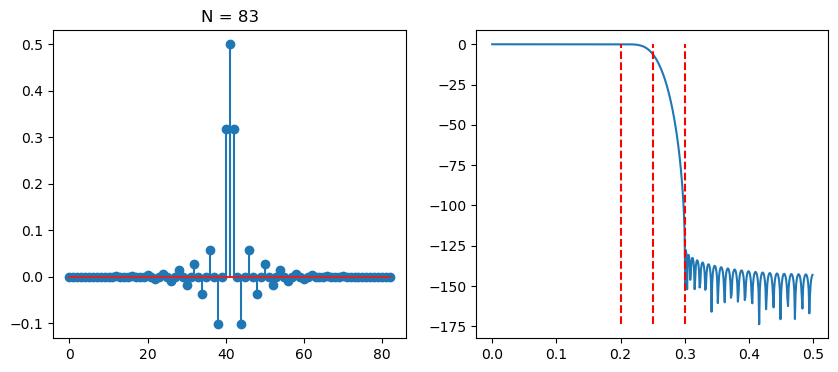

In [199]:
def FIR(x, fir_coeff, state = None):
    N = len(x)
    M = len(fir_coeff)
    if state == None:
        delay_line = np.zeros(M)
    else:
        delay_line = state
    y = np.zeros(N)
    for n in range(N):
        delay_line[1:] = delay_line[:M-1]
        delay_line[0] = x[n]
        for m in range(M):
            y[n] += delay_line[m] * fir_coeff[m]
    return y

def FIR_(x, fir_coeff):
    y = np.convolve(x, fir_coeff)
    return y

D = 2
n_FIR = 1
ripple = 1e-5
attenuation = 90 # in dB
transition_width = 0.05
fir_coeff = gen_FIR_opt(n_FIR, D, ripple, attenuation, transition_width, symetric = True)
N = len(fir_coeff)

figH = 4
ax_x = 1; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.5 * figH, 1 * figH))
plt.subplot(ax_x, ax_y, 1)
stem_FIR(fir_coeff, '', '', f"N = {N}", show = False)
plt.subplot(ax_x, ax_y, 2)
plot_FIR(fir_coeff, show = False)

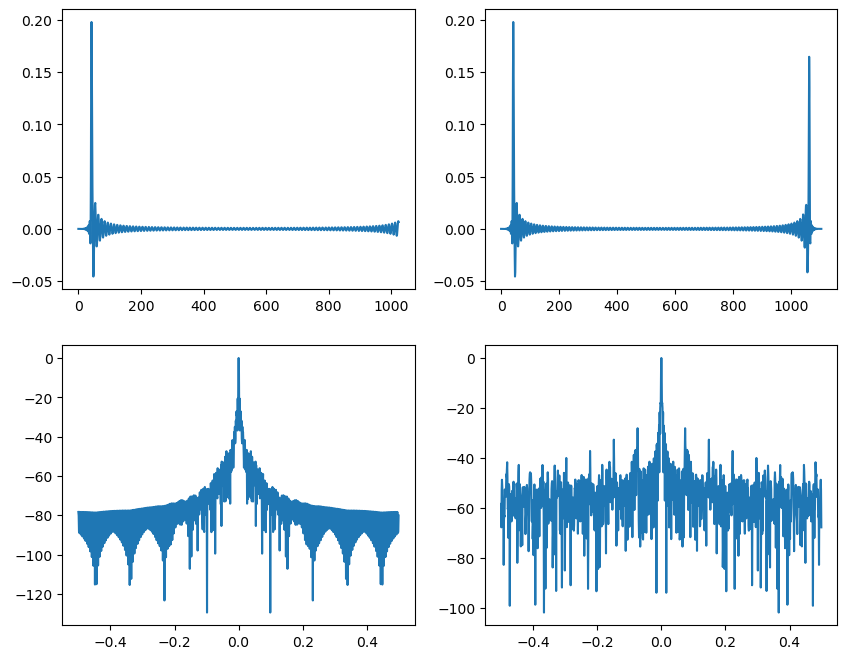

In [200]:
y = FIR(x, fir_coeff)
y_ = FIR_(x, fir_coeff)

y_dB = 20*np.log10(np.abs(np.fft.fft(y)))
y_dB -= np.max(y_dB)
y_dB_ = 20*np.log10(np.abs(np.fft.fft(y_)))
y_dB_ -= np.max(y_dB_)

figH = 4
ax_x = 2; ax_y = 2
plt.subplots(ax_x, ax_y, figsize=(2.5 * figH, 2 * figH))
plt.subplot(ax_x, ax_y, 1)
plot_signal(y, show = False)
plt.subplot(ax_x, ax_y, 2)
plot_signal(y_, show = False)
plt.subplot(ax_x, ax_y, 3)
plot_spectrum(y_dB, show = False)
plt.subplot(ax_x, ax_y, 4)
plot_spectrum(y_dB_, show = False)

In [ ]:
x_ = np.concatenate((x, x[:len(fir_coeff)]))
y = signal.lfilter(fir_coeff, 1.0, x)
y = y[int(len(fir_coeff)/2):]

y_ = FIR(x, fir_coeff)
y_ = y_[np.ceil(len(fir_coeff)/2):]

figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, 1 * figH))
plt.subplot(1, 2, 1)
plot_spectrum(y, show = False)
plt.subplot(1, 2, 2)
plot_spectrum(y_, show = False)

print(y_res)

In [ ]:
x_ = np.concatenate((x, x[:len(fir_coeff)]))
y = signal.lfilter(fir_coeff, 1.0, x_)
y = y[int(len(fir_coeff)):]
y_ = FIR(x_, fir_coeff)
y_ = y_[int(len(fir_coeff)):]

y = y[::D]
y_ = y_[::D]

figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, 1 * figH))
plt.subplot(1, 2, 1)
plot_spectrum(y, show = False)
plt.subplot(1, 2, 2)
plot_spectrum(y_, show = False)

In [ ]:
poly_coeff = make_polyphase_coeff(fir_coeff, D)
x_periodic = np.concatenate((x, x[:len(fir_coeff)-1]))

y = 0
y_ = 0
for d in range(D):
    fir_in = x_periodic[d::D]
    tmp_ = FIR(fir_in, poly_coeff[D - 1 - d])
    tmp = signal.lfilter(poly_coeff[D - 1 - d], 1.0, fir_in)
    print(len(tmp), len(tmp_))
    tmp = tmp[int(len(fir_coeff)/D):]
    tmp_ = tmp_[int(len(fir_coeff)/D):]
    y += tmp
    y_ += tmp_

figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, 1 * figH))
plt.subplot(1, 2, 1)
plot_spectrum(y, show = False)
plt.subplot(1, 2, 2)
plot_spectrum(y_, show = False)

In [ ]:
def FIR_(x, fir_coeff):
    """ Function that performs direct FIR filtering. """
    m = len(fir_coeff)
    n = len(x) + m - 1
    y = np.zeros(n)
    x_ = np.append(x, np.zeros(n - len(x)))
    delay_line = CircBuff(len(fir_coeff))
    for i in range(n):
        delay_line.add(x_[i])
        delay_line_ = delay_line.get()
        acc = 0
        for j in range(m):
            acc += delay_line_[j] * fir_coeff[j]
        y[i] = acc
    return y


In [ ]:
x_ = np.concatenate((x, x[:len(fir_coeff)]))
y = signal.lfilter(fir_coeff, 1.0, x)
# y = y[int(len(fir_coeff)/2):]

y_ = FIR_(x, fir_coeff)
y_ = y_[int(len(fir_coeff)/2):]

print(len(y), len(y_))

figH = 4
plt.subplots(1, 2, figsize=(2.7 * figH, 1 * figH))
plt.subplot(1, 2, 1)
plot_spectrum(y, show = False)
plt.subplot(1, 2, 2)
plot_spectrum(y_, show = False)

In [ ]:
a = np.ones(4)
b = np.ones(3)
c = np.convolve(a, b)
print(len(c))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1
[1.01356454 1.01356454 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
2
[0.18054327 0.18054327 1.01356454 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
3
[1.91963968 1.91963968 0.18054327 1.01356454 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.        ]
4
[-0.394502   -0.394502    1.91963968  0.18054327  1.01356454  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
5
[ 0.80901699  0.80901699 -0.394502    1.91963968  0.18054327  1.01356454
  0.          0.          0.          0.          0.          0.
  0.          0.          0

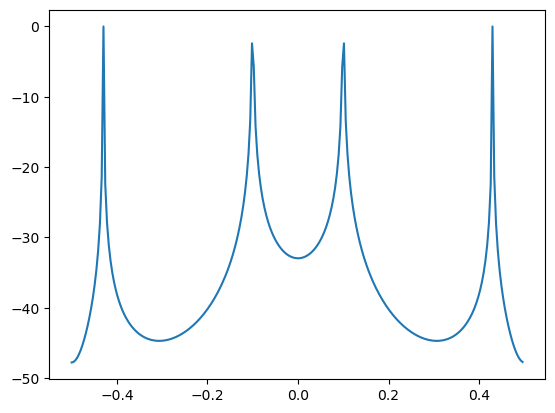

In [40]:
def firDirect(h, x, state = None):
    M = len(h)
    if state == None:
        delayLine = np.zeros(M)
    else:
        delayLine = state
    
    y = np.zeros(len(x))
    for n in range(len(x)):
        delayLine[1:] = delayLine[:M-1]
        print(delayLine)
        print(n)
        delayLine[0] = x[n]
        for m in range(M):
            y[n] += h[m]*delayLine[m]
    
    return y

h = np.array([-0.0136, -0.0139, 0.0254, 0.0523, -0.0124, -0.0880, 0.0252, 0.3169, \
              0.4807, 0.3169, 0.0252, -0.0880, -0.0124, 0.0523, 0.0254, -0.0139, -0.0136])

n = np.arange(len(h))

# fig = plt.figure(figsize = (10,4))
# plt.subplots_adjust(bottom=0.25, wspace = 0.4)
# # Stem filter
# ax1 = fig.add_subplot(1,2,1)
# ax1.stem(n, h)
# ax1.set_xlabel(r'$n$')
# ax1.set_ylabel(r'$h[n]$')

# Definisanje ulaznog signala, zbir dve sinusoide
F1 = 0.1 
F2 = 0.43 
N = 256
n = np.arange(N) 
x = np.sin(2*np.pi*F1*n) + np.sin(2*np.pi*F2*n)

y = firDirect(h, x)
print(len(x), len(y))

# Provera ispravnosti funkcije
yScipy = signal.lfilter(h, 1, x)
print(sum(abs(yScipy - y)))

# # Stem input
# ax2 = fig.add_subplot(1,2,2)
# ax2.plot(n, x, label = 'Ulaz')
# ax2.plot(n, y, label = 'Izlaz')
# ax2.set_xlabel(r'$n$')
# ax2.set_ylabel(r'$x[n], y[n]$')
# ax2.legend(loc = 'upper right');

plot_spectrum(x)

In [ ]:
plot_spectrum(y)